# Dependencies

In [4]:
from __future__ import annotations

import itertools
import math
from pathlib import Path
import re
from typing import Any, Optional, Union
import warnings
import seaborn as sns
import sys
sys.path.append('../Packages/tectoniq')

import geopandas
import matplotlib
import matplotlib.axes
import matplotlib.cm
import matplotlib.figure
import matplotlib.pyplot
import mpl_toolkits.mplot3d
import numpy
import pandas
from shapely import Point
from sklearn.linear_model import LinearRegression
from scipy.optimize import Bounds
import scipy.stats

from tectoniq.datasets import Mercedes
from tectoniq.functions import IFunction, Polynomial, Power, PowerWithOffset
from tectoniq.geometry import distance, distance_to_line, distance_to_line_segment
from tectoniq.optimization import fit_function

import plotly.graph_objs as go
import plotly.express as px
%load_ext autoreload
%autoreload 2

# Configuration

In [6]:
# DOMAIN_COLUMN = Mercedes.DOMAIN_COLUMN
GEOMETRY_COLUMN = Mercedes.GEOMETRY_COLUMN
ID_COLUMN = Mercedes.ID_COLUMN
RADIUS: float = 20
SAMPLE_COUNT_THRESHOLD: int = 20
TARGET_COLUMN: str = "Au (ppm)"
THRESHOLD: float = 3

COLUMN_FIT_OPTIONS: dict[str, dict[str, Any]] = {
    "(2Ca+Na+K)/Al": {},
    "K/Al": {},
    "As/Al": {},
    "K/(Al-Na)": {},
    "CCPI": {},
    "Ishikawa": {},
    "Na/Al": {},
    "Fe (%)": {},
    "Ca (%)": {},
    "Na (%)": {},
    "K (%)": {},
    "Al (%)": {},
    "As (ppm)": {},
    "Cu (ppm)": {},
    "Mg (%)": {}
}
COLUMN_LIMITS: dict[str, tuple[float, float]] = {
    "(2Ca+Na+K)/Al": (0, 2.5),
    "K/Al": (0, 1.5),
    "As/Al": (0, 2000),
    "K/(Al-Na)": (-0.25, 1.5),
    "CCPI": (0, 1),
    "Ishikawa": (0, 100),
    "Na/Al": (0, 1.5),
    "Fe (%)": (0, 10),
    "Ca (%)": (0, 30),
    "Na (%)": (0, 10),
    "K (%)": (0, 10),
    "Al (%)": (0, 10),
    "As (ppm)": (0, 600),
    "Cu (ppm)": (0, 300),
    "Mg (%)": (0, 5),
}

RATIO_COLUMNS: list[str] = [TARGET_COLUMN, "(2Ca+Na+K)/Al", "K/Al", "As/Al", "K/(Al-Na)", "CCPI", "Ishikawa", "Na/Al"]
RATIO_CONSTITUTENT_COLUMNS: list[str] = ["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "As (ppm)", "Cu (ppm)", "Mg (%)"]

DOMAIN_1_SUBSET_LINE: tuple[Point, Point] = Point(549250, 3356800), Point(550000, 3355500)
NULL_DOMAIN_BOTTOM_LEFT = Point(551200, 3355600)
NULL_DOMAIN_TOP_RIGHT = Point(551500, 3355850)

matplotlib.interactive(True)
warnings.filterwarnings("ignore")

# Utilities

In [7]:
def get_units(column: str) -> Optional[str]:
    unit_match: re.Match = re.search(r"\((.+)\)", column)
    return unit_match.group() if unit_match else None

# Data

In [8]:
data_frame: geopandas.GeoDataFrame = Mercedes.latest(Path("../Data"))

In [5]:
data_frame[['Easting', 'Northing']].iloc[0]

Easting      554915.0
Northing    3375534.0
Name: 0, dtype: float64

In [15]:
data_frame['Easting'].min()

264555.07

In [16]:
data_fram

3302454.0

# Refinement

In [8]:
domain_1_subset_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[GEOMETRY_COLUMN].apply(lambda x: distance_to_line_segment(x, DOMAIN_1_SUBSET_LINE[0], DOMAIN_1_SUBSET_LINE[1])).le(200)][data_frame[TARGET_COLUMN].ge(THRESHOLD)]

X: numpy.array[list[float]] = numpy.array(domain_1_subset_data_frame[GEOMETRY_COLUMN].apply(lambda x: [x.x]).to_list())
y: numpy.array[float] = numpy.array(domain_1_subset_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).tolist())

linear_regression: LinearRegression = LinearRegression().fit(X, y)

domain_1_subset_line_point_1_x: float = domain_1_subset_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).min() - RADIUS
domain_1_subset_line_point_1_y: float = linear_regression.predict([[domain_1_subset_line_point_1_x]])[0]
domain_1_subset_line_point_2_x: float = domain_1_subset_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).max() + RADIUS
domain_1_subset_line_point_2_y: float = linear_regression.predict([[domain_1_subset_line_point_2_x]])[0]
domain_1_subset_line = Point(domain_1_subset_line_point_1_x, domain_1_subset_line_point_1_y), Point(domain_1_subset_line_point_2_x, domain_1_subset_line_point_2_y)

print(f"Adjusting manual subset line from ({DOMAIN_1_SUBSET_LINE[0].x}, {DOMAIN_1_SUBSET_LINE[0].y}), ({DOMAIN_1_SUBSET_LINE[1].x}, {DOMAIN_1_SUBSET_LINE[1].y}) -> ({domain_1_subset_line[0].x}, {domain_1_subset_line[0].y}), ({domain_1_subset_line[1].x}, {domain_1_subset_line[1].y})")

Adjusting manual subset line from (549250.0, 3356800.0), (550000.0, 3355500.0) -> (549211.0, 3356921.166252398), (549950.0, 3355597.8320937883)


# Exploration

<Axes: >

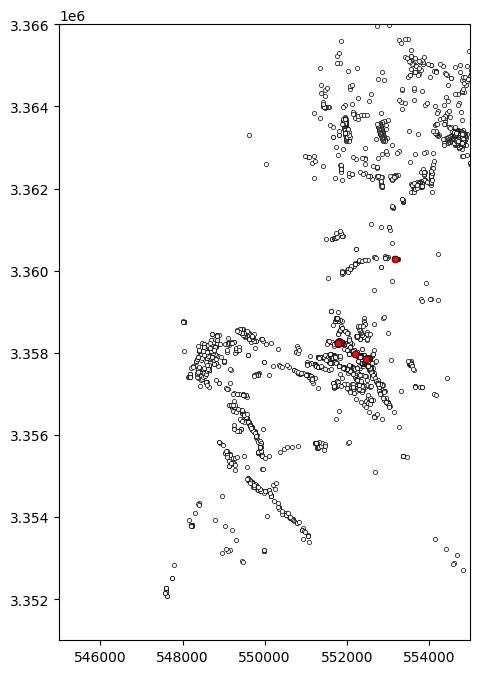

In [131]:
figure, axes = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize = (8, 8))

# Domains 1, 2, and 3
axes.set_xlim(xmin = 545000, xmax = 555000)
axes.set_ylim(ymin = 3351000, ymax = 3366000)

data_frame.plot(ax=axes, legend=True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
# data_frame[data_frame[TARGET_COLUMN].ge(THRESHOLD)].plot(ax=axes, legend=True, color="yellow", markersize=25, linewidth=0.5, edgecolors="black")

# data_frame[data_frame['SampleNumber'] == 'M021872'].plot(ax=axes, legend=True, color="green", markersize=25, linewidth=0.5, edgecolors="black")
# data_frame[data_frame["Domain"] == 1][data_frame[TARGET_COLUMN].ge(3)].plot(ax=axes, legend=True, color="green", markersize=25, linewidth=0.5, edgecolors="black")
# data_frame[data_frame["Domain"] == 2][data_frame[TARGET_COLUMN].ge(0.5)].plot(ax=axes, legend=True, color="blue", markersize=25, linewidth=0.5, edgecolors="black")
# data_frame[data_frame["Domain"] == 4][data_frame[TARGET_COLUMN].ge(0.5)].plot(ax=axes, legend=True, color="red", markersize=25, linewidth=0.5, edgecolors="black")
# data_frame[data_frame[GEOMETRY_COLUMN].apply(lambda x: distance_to_line_segment(x, domain_1_subset_line[0], domain_1_subset_line[1])).le(200)][data_frame[TARGET_COLUMN].ge(THRESHOLD)].plot(ax=axes, legend=True, color="yellow", markersize=25, linewidth=0.5, edgecolors="black")

data_frame[~data_frame['im_url'].isna()].plot(ax=axes, legend=True, color="red", markersize=25, linewidth=0.5, edgecolors="black")
# axes.plot([domain_1_subset_line[0].x, domain_1_subset_line[1].x], [domain_1_subset_line[0].y, domain_1_subset_line[1].y])

In [136]:
numpy.isna(data_frame[~data_frame['im_url'].isna()].iloc[0]['im_url'])

AttributeError: module 'numpy' has no attribute 'isna'

In [138]:
import pandas as pd

pd.isnull(data_frame.iloc[0]['im_url'])

True

In [140]:
data_frame[~data_frame['im_url'].isna()]['Au (ppm)']

2174    28.40
2177     4.52
2178     4.94
3442     3.71
3497     3.37
3663     5.51
3664     6.35
3752     4.92
3804     3.43
3828    10.00
4705     7.00
Name: Au (ppm), dtype: float64

In [11]:
data_frame[data_frame['SampleNumber'] == 'EX101976']

,SampleNumber,Easting,Northing,Latitude,Longitude,Elevation,Area,Type,Sampler,Au (ppm),...,Zr (ppm),(2Ca+Na+K)/Al,K/Al,As/Al,K/(Al-Na),CCPI,Ishikawa,Na/Al,Geometry,Domain
2174,EX101976,551815.0,3358262.0,30.35514,-110.46084,NaN,Mercedes,CHIP ROCK,"CB, R",28.4,...,NaN,1.05814,0.934109,29.457364,0.964,0.899558,92.533137,0.031008,POINT (551815.000 3358262.000),1.0


In [17]:
data_frame['Easting']

0       554915.000000
1       557436.131684
2       557617.225660
3       557799.127065
4       557702.554000
            ...      
6682    552484.255100
6683    552569.535700
6685    547580.874900
6686    548194.386700
6687    548194.386700
Name: Easting, Length: 6594, dtype: float64

In [19]:
data_frame['Northing'][0]

3375534.0

In [8]:
# Create plotly figure
fig = go.Figure()

fig.update_layout(
    autosize=False,
    width=700,
    height=900,
    legend=dict(
        x=0,
        y=1,
        traceorder="reversed",
        title_font_family="Times New Roman",
        font=dict(
            size=12,
            color="black"
        ),
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=2
    ),
    scene_camera_eye=dict(x=10, y=10, z=1),
    # yaxis=dict(
    #     range=[0, 100]
    # ),
    xaxis=dict(
        range=[547000, 600000]
    )
)


# Plot all points
fig.add_trace(go.Scatter(
    x=data_frame['Geometry'].apply(lambda x: x.x),
    y=data_frame['Geometry'].apply(lambda x: x.y),
    mode='markers',
    name='All Points',
    marker=dict(color='white', size=4, line=dict(width=0.5, color='black')),
))

# Plot points above threshold

fig.add_trace(go.Scatter(
    x=data_frame[(data_frame['Domain']==1)]['Geometry'].apply(lambda x: x.x),
    y=data_frame[(data_frame['Domain']==1)]['Geometry'].apply(lambda x: x.y),
    mode='markers',
    name='Domain 1',
    marker=dict(color='lightgreen', size=4, line=dict(width=0.5, color='black')),
    hovertemplate =
    "Northing: %{x}<br>" + "Easting: %{y}<br>" 
    ))

fig.add_trace(go.Scatter(
    x=data_frame[(data_frame['Domain']==1)&(data_frame[TARGET_COLUMN].ge(THRESHOLD))]['Geometry'].apply(lambda x: x.x),
    y=data_frame[(data_frame['Domain']==1)&(data_frame[TARGET_COLUMN].ge(THRESHOLD))]['Geometry'].apply(lambda x: x.y),
    mode='markers',
    name='Domain 1',
    marker=dict(color='green', size=5, line=dict(width=0.5, color='black')),
    hovertemplate =
    "Northing: %{x}<br>" + "Easting: %{y}<br>" 
))

fig.add_trace(go.Scatter(
    x=data_frame[(data_frame['Domain']==4)]['Geometry'].apply(lambda x: x.x),
    y=data_frame[(data_frame['Domain']==4)]['Geometry'].apply(lambda x: x.y),
    mode='markers',
    name='Domain 4',
    marker=dict(color='red', size=5, line=dict(width=0.5, color='black')),
    hovertemplate =
    "Northing: %{x}<br>" + "Easting: %{y}<br>" 
))


fig.update_layout(
    xaxis=dict(range=[545000, 555000]),
    yaxis=dict(range=[3351000, 3366000])
)

fig.update_layout(
    title=dict(text="Area Scatter Plot", font=dict(size=20), x=0.5, y=0.95),
)
fig.update_xaxes(title_text='Easting')
fig.update_yaxes(title_text='Northing')

# Show plot
fig.show()

In [9]:
fig.write_html("interactive_plot.html")


In [194]:
# sns.kdeplot(data=data_frame[(data_frame['Domain'] == 1 ) & (data_frame[TARGET_COLUMN].ge(THRESHOLD))], x='Na (%)', fill=True)
# sns.kdeplot(data=data_frame[(data_frame['Domain'] == 1 ) & (data_frame[TARGET_COLUMN].lt(THRESHOLD))], x='Na (%)', fill=False, color='orange')


In [195]:
sns.kdeplot(data=data_frame[(data_frame['Domain'] == 1 ) & (data_frame[TARGET_COLUMN].ge(THRESHOLD))], x='K (%)', fill=True)
sns.kdeplot(data=data_frame[(data_frame['Domain'] == 1 ) & (data_frame[TARGET_COLUMN].lt(THRESHOLD))], x='K (%)', fill=False, color='orange')
# sns.kdeplot(data=data_frame[(data_frame['Domain'] == 1 ) & (data_frame[TARGET_COLUMN].lt(THRESHOLD))], x='K (%)', fill=True)
# sns.kdeplot(data=data_frame[(data_frame['Domain'] == 1 ) & (data_frame[TARGET_COLUMN].lt(THRESHOLD))], x='Ca (%)', fill=True)
# sns.kdeplot(data=data_frame[(data_frame['Domain'] == 1 ) & (data_frame[TARGET_COLUMN].lt(THRESHOLD))], x='Mg (%)', fill=True)

In [196]:
# sns.kdeplot(data=data_frame[(data_frame['Domain'] == 1 ) & (data_frame[TARGET_COLUMN].ge(THRESHOLD))], x='Ca (%)', fill=True)
# sns.kdeplot(data=data_frame[(data_frame['Domain'] == 1 ) & (data_frame[TARGET_COLUMN].lt(THRESHOLD))], x='Ca (%)', fill=False, color='orange')

In [197]:
# sns.kdeplot(data=data_frame[(data_frame['Domain'] == 1 ) & (data_frame[TARGET_COLUMN].ge(THRESHOLD))], x='Ishikawa', fill=True)
# sns.kdeplot(data=data_frame[(data_frame['Domain'] == 1 ) & (data_frame[TARGET_COLUMN].lt(THRESHOLD))], x='Ishikawa', fill=False, color='orange')

In [198]:
# sns.kdeplot(data=data_frame[(data_frame['Domain'] == 1 ) & (data_frame[TARGET_COLUMN].ge(THRESHOLD))], x='CCPI', fill=True)
# sns.kdeplot(data=data_frame[(data_frame['Domain'] == 1 ) & (data_frame[TARGET_COLUMN].lt(THRESHOLD))], x='CCPI', fill=False, color='orange')

### Distance Density Plot

In [38]:
def create_density_plot(data_frame: geopandas.GeoDataFrame, columns: str):
    for index, row in data_frame.sort_values(by = [TARGET_COLUMN], ascending = [False]).iterrows():
        if row[TARGET_COLUMN] < THRESHOLD:
            break
        other_rows: geopandas.GeoDataFrame = data_frame[data_frame.index != index]
        other_rows = other_rows[other_rows[GEOMETRY_COLUMN].apply(lambda x: distance(x, row[GEOMETRY_COLUMN]) <= RADIUS)]

        if len(other_rows) < SAMPLE_COUNT_THRESHOLD:
            continue

        subset_index: pandas.Index = pandas.Index([index]).union(other_rows.index)
        subset_data_frame: geopandas.GeoDataFrame = data_frame.loc[subset_index]

        DISTANCE_COLUMN: str = "Distance"
        NUMBER_OF_COLUMNS: int = 2
        NUMBER_OF_ROWS: int = int(math.ceil(len(columns) / NUMBER_OF_COLUMNS))

        subset_data_frame[DISTANCE_COLUMN] = subset_data_frame.apply(lambda x: distance(x[GEOMETRY_COLUMN], row[GEOMETRY_COLUMN]), axis = 1)
        
        figure: matplotlib.figure.Figure
        axes: numpy.ndarray[matplotlib.axes.Axes]
        figure, axes = matplotlib.pyplot.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, figsize = (8, 8))

        for index, column in enumerate(columns):
            y_min: Optional[float] = None
            y_max: Optional[float] = None

            if column in COLUMN_LIMITS:
                y_min = COLUMN_LIMITS[column][0]
                y_max = COLUMN_LIMITS[column][1]
            
            row_index: int = int(math.floor(index/NUMBER_OF_COLUMNS))
            column_index: int = index % NUMBER_OF_COLUMNS
            sns.kdeplot(subset_data_frame, x=DISTANCE_COLUMN, y=column, ax=axes[row_index, column_index], fill=False, cmap="viridis", thresh=0)
            axes[row_index, column_index].axvline(x=15.206906, color='gray', label='axvline - % of full height')


            if column in COLUMN_FIT_OPTIONS:
                best_fit_subset_data_frame: geopandas.GeoDataFrame = subset_data_frame[subset_data_frame[column].apply(lambda x: (y_min is None or y_min <= x) and (y_max is None or x <= y_max))]
                linear_regression_result: scipy.stats.LinregressResult = scipy.stats.linregress(best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column])
                best_fit_function: IFunction = Polynomial([linear_regression_result.intercept, linear_regression_result.slope])
                # best_fit_function: IFunction = fit_function(Polynomial, best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column], bounds = Bounds([-1000, -1000], [100, 100]))
                best_fit_X, best_fit_Y = best_fit_function.to_discrete(best_fit_subset_data_frame[DISTANCE_COLUMN].min(), best_fit_subset_data_frame[DISTANCE_COLUMN].max(), 1000)
                axes[row_index, column_index].plot(best_fit_X, best_fit_Y, linestyle = "-", color = "red")
                axes[row_index, column_index].set_xlabel(str(best_fit_function))

        figure.supxlabel("Distance (m)")
        title: str = f"{row["SampleNumber"]} - {row[TARGET_COLUMN]} {TARGET_COLUMN} - {len(other_rows)} others in {RADIUS}m"
        figure.suptitle(title)
        figure.tight_layout()
        figure.show()
        break

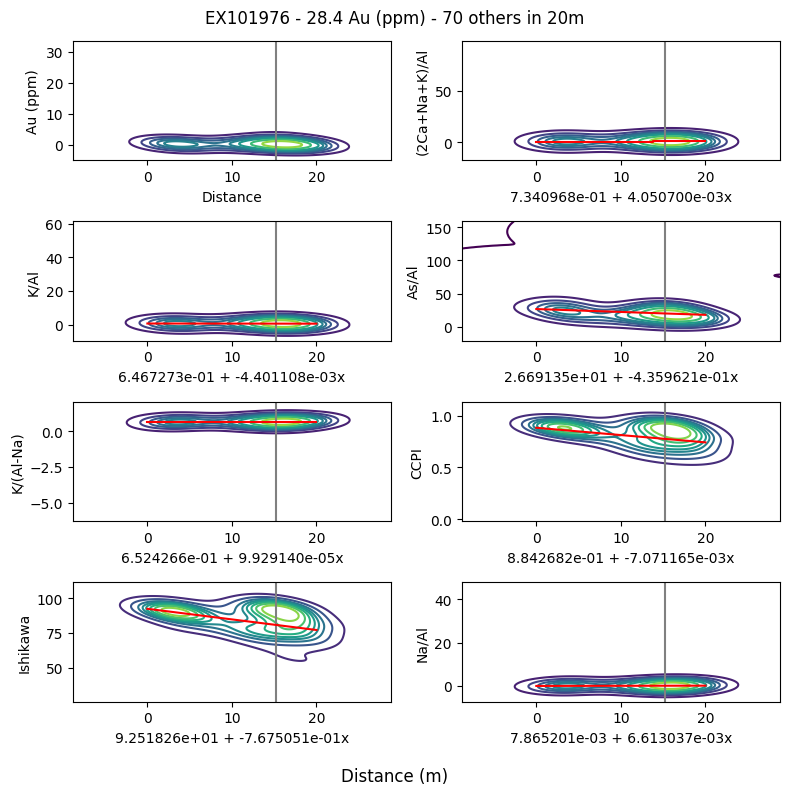

In [39]:
create_density_plot(data_frame, RATIO_COLUMNS)

In [259]:
def create_null_domain_density_plots(data_frame: geopandas.GeoDataFrame, reference_points_data_frame: geopandas.GeoDataFrame, columns: list[str]):
    for index, row in reference_points_data_frame.iterrows():
        subset_data_frame: geopandas.DataFrame = data_frame.copy()

        DISTANCE_COLUMN: str = "Distance"
        NUMBER_OF_COLUMNS: int = 2
        NUMBER_OF_ROWS: int = int(math.ceil(len(columns) / NUMBER_OF_COLUMNS))

        subset_data_frame[DISTANCE_COLUMN] = subset_data_frame.apply(lambda x: distance(x[GEOMETRY_COLUMN], row[GEOMETRY_COLUMN]), axis = 1)
        
        figure: matplotlib.figure.Figure
        axes: numpy.ndarray[matplotlib.axes.Axes]
        figure, axes = matplotlib.pyplot.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, figsize = (8, 8))

        for index, column in enumerate(columns):            
            y_min: Optional[float] = None
            y_max: Optional[float] = None

            if column in COLUMN_LIMITS:
                y_min = COLUMN_LIMITS[column][0]
                y_max = COLUMN_LIMITS[column][1]

            
            row_index: int = int(math.floor(index/NUMBER_OF_COLUMNS))
            column_index: int = index % NUMBER_OF_COLUMNS
            sns.kdeplot(subset_data_frame, x=DISTANCE_COLUMN, y=column, ax=axes[row_index, column_index], fill=False, cmap="viridis", thresh=0)

 
            axes[row_index, column_index].set_ylabel(column)
            axes[row_index, column_index].set_ylim(y_min, y_max)

            if column in COLUMN_FIT_OPTIONS:
                best_fit_subset_data_frame: geopandas.GeoDataFrame = subset_data_frame[subset_data_frame[column].apply(lambda x: (y_min is None or y_min <= x) and (y_max is None or x <= y_max))]
                # linear_regression_result: scipy.stats.LinregressResult = scipy.stats.linregress(best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column])
                # best_fit_function: IFunction = Polynomial([linear_regression_result.intercept, linear_regression_result.slope])
                best_fit_function: IFunction = fit_function(Polynomial, best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column], bounds = Bounds([0], [10000]))
                best_fit_X, best_fit_Y = best_fit_function.to_discrete(0, 150, 1000)
                axes[row_index, column_index].plot(best_fit_X, best_fit_Y, linestyle = "-", color = "red")
                axes[row_index, column_index].set_xlabel(str(best_fit_function))

            axes[row_index, column_index].set_xlim(0, 150)

        figure.supxlabel("Distance (m)")
        title: str = f"{row["SampleNumber"]} - {row[TARGET_COLUMN]} {TARGET_COLUMN}"

        figure.suptitle(title)
        figure.tight_layout()
        figure.show()


In [309]:
null_domain_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[GEOMETRY_COLUMN].apply(lambda x: NULL_DOMAIN_BOTTOM_LEFT.x <= x.x and x.x <= NULL_DOMAIN_TOP_RIGHT.x and NULL_DOMAIN_BOTTOM_LEFT.y <= x.y and x.y <= NULL_DOMAIN_TOP_RIGHT.y)]
null_domain_reference_data_frame: geopandas.GeoDataFrame = null_domain_data_frame[null_domain_data_frame["SampleNumber"] == "M021872"]

create_null_domain_density_plots(null_domain_data_frame, null_domain_data_frame[null_domain_data_frame["SampleNumber"] == "M021872"], RATIO_COLUMNS)
# create_null_domain_density_plots(null_domain_data_frame, null_domain_data_frame[null_domain_data_frame["SampleNumber"] == "M021872"], RATIO_CONSTITUTENT_COLUMNS)

In [38]:
TARGET_COLUMN

'Au (ppm)'

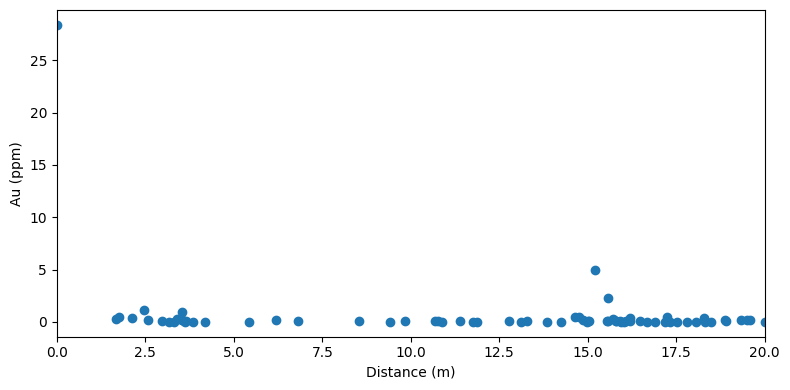

In [100]:
data_frame.iloc[5274]['Au (ppm)']

0.263

In [79]:
newshape=(int(figure.bbox.bounds[3]), int(figure.bbox.bounds[2]))

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import base64
from PIL import Image

# Render the figure into a buffer

def convert_figure_to_np_array(figure):

    canvas = FigureCanvas(figure)
    canvas.draw()

    # Convert the buffer to a NumPy array
    # First get the RGBA buffer from the figure
    buf = canvas.buffer_rgba()
    # Convert to a NumPy array
    array = np.asarray(buf)
    return array


def np_image_to_base64(im_matrix):
    im = Image.fromarray(im_matrix)
    im = im.convert('RGB')
    buffer = io.BytesIO()
    im.save(buffer, format="png")
    encoded_image = base64.b64encode(buffer.getvalue()).decode()
    im_url = "data:image/png;base64, " + encoded_image
    return im_url

In [10]:
data_frame['im_url'] = np.nan

In [11]:
# row = data_frame[data_frame['SampleNumber'] == 'EX101976']
# index = row.index[0]
def get_im_urls(data_frame: geopandas.GeoDataFrame, TARGET_COLUMN: str  = 'Au (ppm)') -> geopandas.GeoDataFrame:
    column = TARGET_COLUMN
    images = []
    for index, row in data_frame.sort_values(by = [TARGET_COLUMN], ascending = [False]).iterrows():
        if row[TARGET_COLUMN] < THRESHOLD:
            print("Breaking")
            break

        other_rows: geopandas.GeoDataFrame = data_frame[data_frame.index != index]
        other_rows = other_rows[other_rows[GEOMETRY_COLUMN].apply(lambda x: distance(x, row[GEOMETRY_COLUMN]) <= RADIUS)]
        if len(other_rows) < SAMPLE_COUNT_THRESHOLD:
            print("Continue")
            continue
        
        subset_index: pandas.Index = pandas.Index([index]).union(other_rows.index)
        subset_data_frame: geopandas.GeoDataFrame = data_frame.loc[subset_index]

        DISTANCE_COLUMN: str = "Distance"
        NUMBER_OF_COLUMNS: int = 1
        NUMBER_OF_ROWS: int = 1

        subset_data_frame[DISTANCE_COLUMN] = subset_data_frame.apply(lambda x: distance(x[GEOMETRY_COLUMN], row[GEOMETRY_COLUMN]), axis = 1)

        figure: matplotlib.figure.Figure
        axes: numpy.ndarray[matplotlib.axes.Axes]
        figure, axes = matplotlib.pyplot.subplots(figsize = (8, 4))
        
        y_min: Optional[float] = None
        y_max: Optional[float] = None

        if column in COLUMN_LIMITS:
            y_min = COLUMN_LIMITS[column][0]
            y_max = COLUMN_LIMITS[column][1]

        row_index: int = int(math.floor(index / NUMBER_OF_COLUMNS))
        column_index: int = index % NUMBER_OF_COLUMNS
        axes.scatter(subset_data_frame[DISTANCE_COLUMN], subset_data_frame[column])
        axes.set_ylabel(column)
        axes.set_ylim(y_min, y_max)
        axes.set_xlim(0, RADIUS)

        axes.set_xlabel("Distance (m)")
            # title: str = f"{row["SampleNumber"]} - {row[TARGET_COLUMN]} {TARGET_COLUMN} - {len(other_rows)} others in {RADIUS}m"

            # figure.suptitle(title)
        fig_array = convert_figure_to_np_array(figure)
        im_url = np_image_to_base64(fig_array)
        data_frame.loc[index, 'im_url'] = im_url

    return data_frame

In [123]:
data_frame.drop('im_url', axis=1, inplace=True)

In [13]:
import io

Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
C

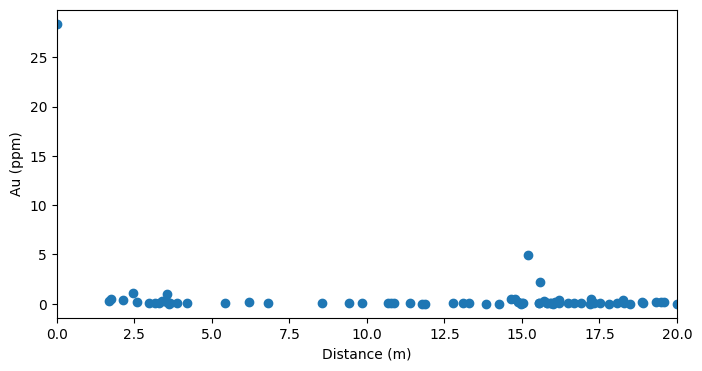

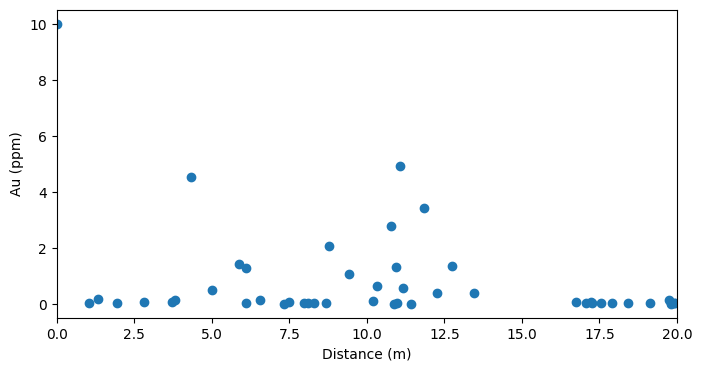

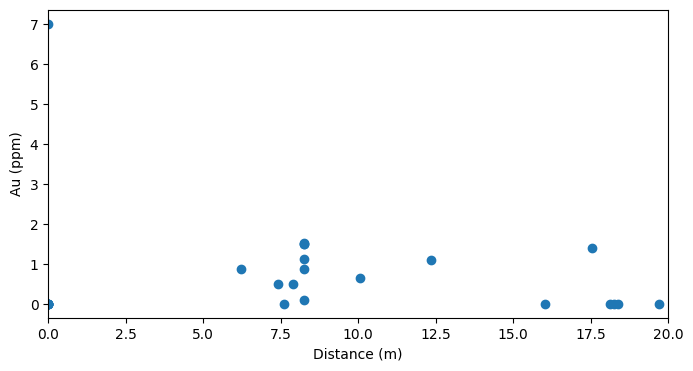

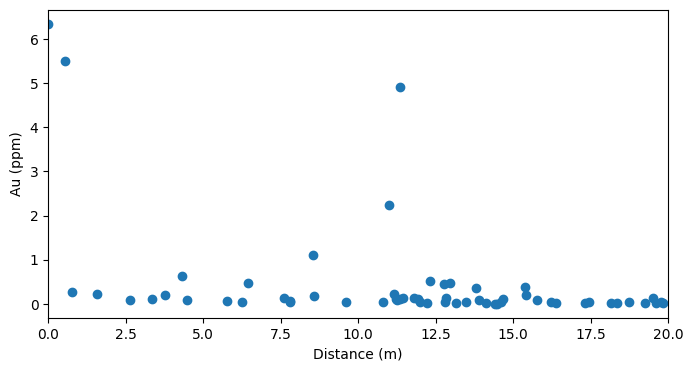

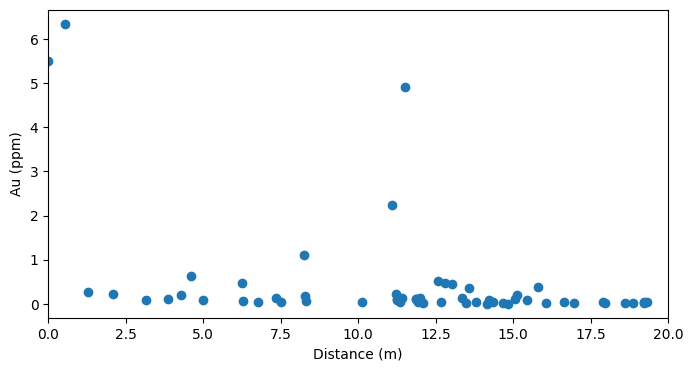

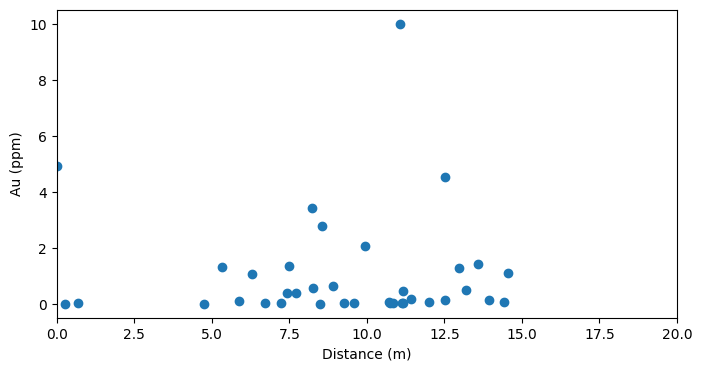

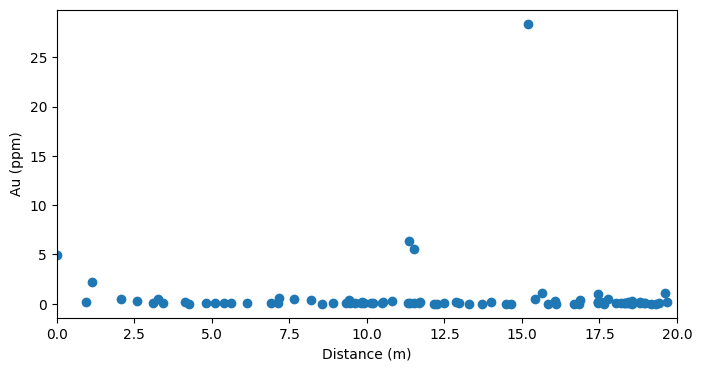

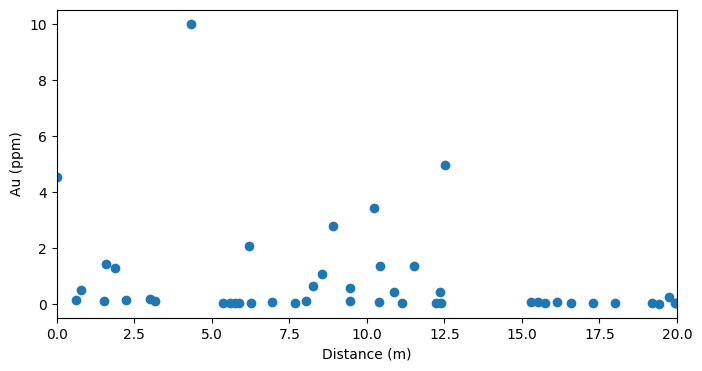

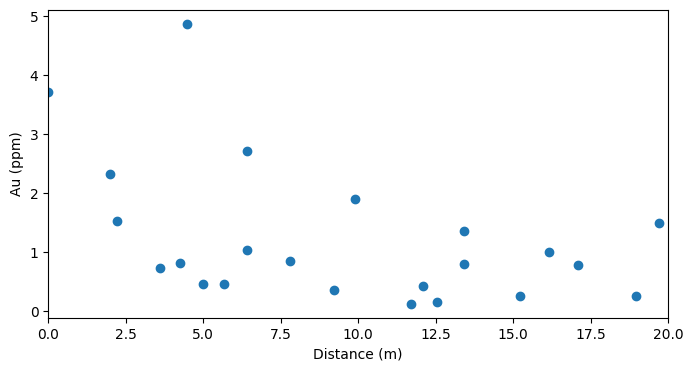

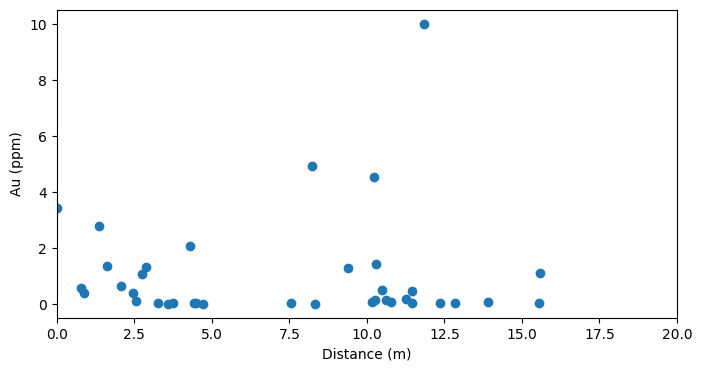

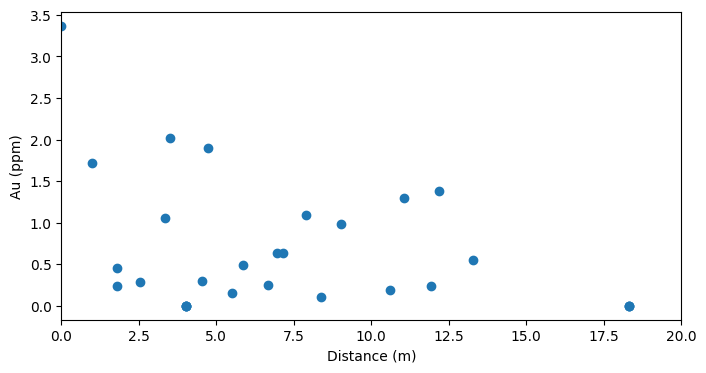

In [14]:
data_frame = get_im_urls(data_frame)

In [18]:
data_frame.to_excel('../dash/data/fingerprint2.xlsx', index=False)

In [143]:
data_frame.head()

,SampleNumber,Easting,Northing,Latitude,Longitude,Elevation,Area,Type,Sampler,Au (ppm),...,(2Ca+Na+K)/Al,K/Al,As/Al,K/(Al-Na),CCPI,Ishikawa,Na/Al,Geometry,Domain,im_url
0,606516,554915.000000,3.375534e+06,30.510858,-110.427675,NaN,La Mesa Ranch,Channel,LHRG,0.010,...,20.732218,0.234310,4.267782,0.350000,0.095604,5.397384,0.330544,POINT (554915.000 3375534.000),NaN,NaN
1,695001,557436.131684,3.377238e+06,30.526114,-110.401306,1272.0,San Antonio Ranch,Soil,PPV-JLO,0.009,...,0.730871,0.328496,2.229551,0.378995,0.664092,60.620945,0.133245,POINT (557436.132 3377237.834),NaN,NaN
2,695002,557617.225660,3.377152e+06,30.525331,-110.399423,1275.0,San Antonio Ranch,Soil,PPV-JLO,0.006,...,0.873351,0.299472,2.229551,0.359746,0.569692,49.317501,0.167546,POINT (557617.226 3377151.993),NaN,NaN
3,695003,557799.127065,3.377069e+06,30.524570,-110.397532,1316.0,San Antonio Ranch,Soil,PPV-JLO,0.007,...,0.619804,0.308068,1.625917,0.370044,0.656773,59.834008,0.167482,POINT (557799.127 3377068.649),NaN,NaN
4,695004,557702.554000,3.377334e+06,30.526968,-110.398524,1286.0,San Antonio Ranch,Soil,PPV-JLO,0.005,...,0.533235,0.192024,1.713442,0.254902,0.618826,46.495807,0.246677,POINT (557702.554 3377333.894),NaN,NaN


In [144]:
data_frame.to_excel('fingerprint.xlsx', index=False)

In [146]:
data_frame = pd.read_excel('../dash/data/fingerprint.xlsx')

In [ ]:
row = data_frame[data_frame['SampleNumber'] == 'EX101976']
index = row.index[0]
columns = [TARGET_COLUMN]

other_rows: geopandas.GeoDataFrame = data_frame[data_frame.index != index]
other_rows = other_rows[other_rows[GEOMETRY_COLUMN].apply(lambda x: distance(x, row[GEOMETRY_COLUMN]) <= RADIUS)]
if len(other_rows) < SAMPLE_COUNT_THRESHOLD:
    print("Continue")

subset_index: pandas.Index = pandas.Index([index]).union(other_rows.index)
subset_data_frame: geopandas.GeoDataFrame = data_frame.loc[subset_index]

DISTANCE_COLUMN: str = "Distance"
NUMBER_OF_COLUMNS: int = 1
NUMBER_OF_ROWS: int = int(math.ceil(len(columns) / NUMBER_OF_COLUMNS))

subset_data_frame[DISTANCE_COLUMN] = subset_data_frame.apply(lambda x: distance(x[GEOMETRY_COLUMN], row[GEOMETRY_COLUMN]), axis = 1)

figure: matplotlib.figure.Figure
axes: numpy.ndarray[matplotlib.axes.Axes]
figure, axes = matplotlib.pyplot.subplots(figsize = (8, 4))

# matplotlib.pyplot.figure(figsize = (8, 4))


for index, column in enumerate(columns):
    y_min: Optional[float] = None
    y_max: Optional[float] = None

    if column in COLUMN_LIMITS:
        y_min = COLUMN_LIMITS[column][0]
        y_max = COLUMN_LIMITS[column][1]

    row_index: int = int(math.floor(index / NUMBER_OF_COLUMNS))
    column_index: int = index % NUMBER_OF_COLUMNS
    axes.scatter(subset_data_frame[DISTANCE_COLUMN], subset_data_frame[column])
    
    # if column in COLUMN_FIT_OPTIONS:
    #     best_fit_subset_data_frame: geopandas.GeoDataFrame = subset_data_frame[subset_data_frame[column].apply(lambda x: (y_min is None or y_min <= x) and (y_max is None or x <= y_max))]
    #     linear_regression_result: scipy.stats.LinregressResult = scipy.stats.linregress(best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column])
    #     best_fit_function: IFunction = Polynomial([linear_regression_result.intercept, linear_regression_result.slope])
    #     # best_fit_function: IFunction = fit_function(Polynomial, best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column], bounds = Bounds([-1000, -1000], [100, 100]))
    #     best_fit_X, best_fit_Y = best_fit_function.to_discrete(best_fit_subset_data_frame[DISTANCE_COLUMN].min(), best_fit_subset_data_frame[DISTANCE_COLUMN].max(), 1000)
    #     axes[row_index, column_index].plot(best_fit_X, best_fit_Y, linestyle = "-", color = "red")
    #     axes[row_index, column_index].set_xlabel(str(best_fit_function))
        
    axes.set_ylabel(column)
    axes.set_ylim(y_min, y_max)
    axes.set_xlim(0, RADIUS)

    axes.set_xlabel("Distance (m)")
    # title: str = f"{row["SampleNumber"]} - {row[TARGET_COLUMN]} {TARGET_COLUMN} - {len(other_rows)} others in {RADIUS}m"

    # figure.suptitle(title)
    figure.tight_layout()
    figure.show()

In [9]:
def create_plots(data_frame: geopandas.GeoDataFrame, columns: list[str]):
    for index, row in data_frame.sort_values(by = [TARGET_COLUMN], ascending = [False]).iterrows():
        if row[TARGET_COLUMN] < THRESHOLD:
            print("Breaking")
            break
        other_rows: geopandas.GeoDataFrame = data_frame[data_frame.index != index]
        other_rows = other_rows[other_rows[GEOMETRY_COLUMN].apply(lambda x: distance(x, row[GEOMETRY_COLUMN]) <= RADIUS)]

        if len(other_rows) < SAMPLE_COUNT_THRESHOLD:
            print("Continue")
            continue

        subset_index: pandas.Index = pandas.Index([index]).union(other_rows.index)
        subset_data_frame: geopandas.GeoDataFrame = data_frame.loc[subset_index]
        
        DISTANCE_COLUMN: str = "Distance"
        NUMBER_OF_COLUMNS: int = 2
        NUMBER_OF_ROWS: int = int(math.ceil(len(columns) / NUMBER_OF_COLUMNS))

        subset_data_frame[DISTANCE_COLUMN] = subset_data_frame.apply(lambda x: distance(x[GEOMETRY_COLUMN], row[GEOMETRY_COLUMN]), axis = 1)
        
        figure: matplotlib.figure.Figure
        axes: numpy.ndarray[matplotlib.axes.Axes]
        figure, axes = matplotlib.pyplot.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, figsize = (8, 8))

        for index, column in enumerate(columns):
            y_min: Optional[float] = None
            y_max: Optional[float] = None

            if column in COLUMN_LIMITS:
                y_min = COLUMN_LIMITS[column][0]
                y_max = COLUMN_LIMITS[column][1]

            row_index: int = int(math.floor(index / NUMBER_OF_COLUMNS))
            column_index: int = index % NUMBER_OF_COLUMNS
            axes[row_index, column_index].scatter(subset_data_frame[DISTANCE_COLUMN], subset_data_frame[column])
            
            if column in COLUMN_FIT_OPTIONS:
                best_fit_subset_data_frame: geopandas.GeoDataFrame = subset_data_frame[subset_data_frame[column].apply(lambda x: (y_min is None or y_min <= x) and (y_max is None or x <= y_max))]
                linear_regression_result: scipy.stats.LinregressResult = scipy.stats.linregress(best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column])
                best_fit_function: IFunction = Polynomial([linear_regression_result.intercept, linear_regression_result.slope])
                # best_fit_function: IFunction = fit_function(Polynomial, best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column], bounds = Bounds([-1000, -1000], [100, 100]))
                best_fit_X, best_fit_Y = best_fit_function.to_discrete(best_fit_subset_data_frame[DISTANCE_COLUMN].min(), best_fit_subset_data_frame[DISTANCE_COLUMN].max(), 1000)
                axes[row_index, column_index].plot(best_fit_X, best_fit_Y, linestyle = "-", color = "red")
                axes[row_index, column_index].set_xlabel(str(best_fit_function))

            axes[row_index, column_index].set_ylabel(column)
            axes[row_index, column_index].set_ylim(y_min, y_max)
            axes[row_index, column_index].set_xlim(0, RADIUS)

        figure.supxlabel("Distance (m)")
        title: str = f"{row["SampleNumber"]} - {row[TARGET_COLUMN]} {TARGET_COLUMN} - {len(other_rows)} others in {RADIUS}m"

        figure.suptitle(title)
        figure.tight_layout()
        figure.show()

Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
Continue
C

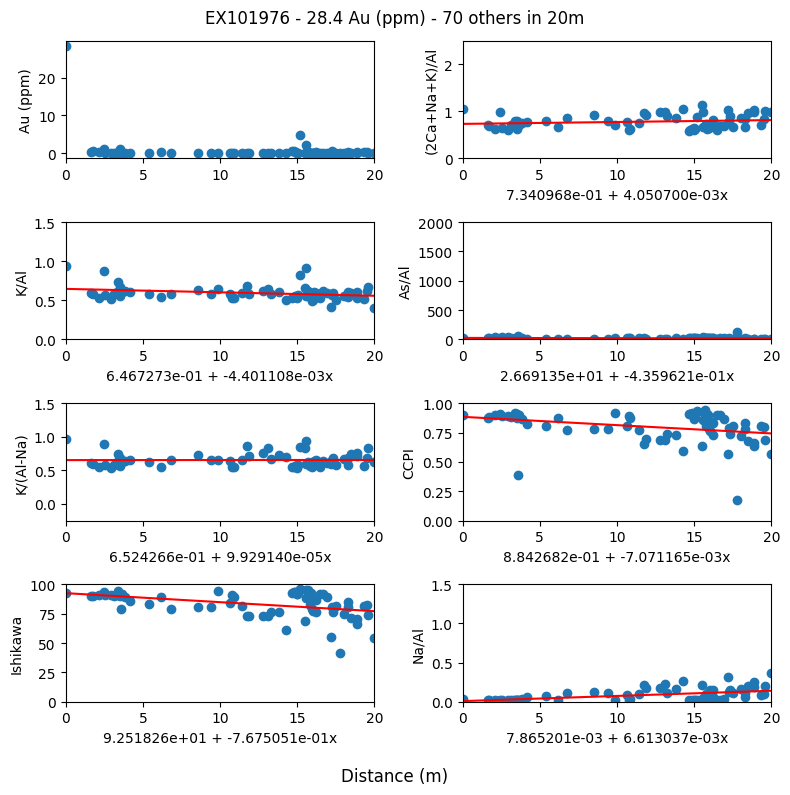

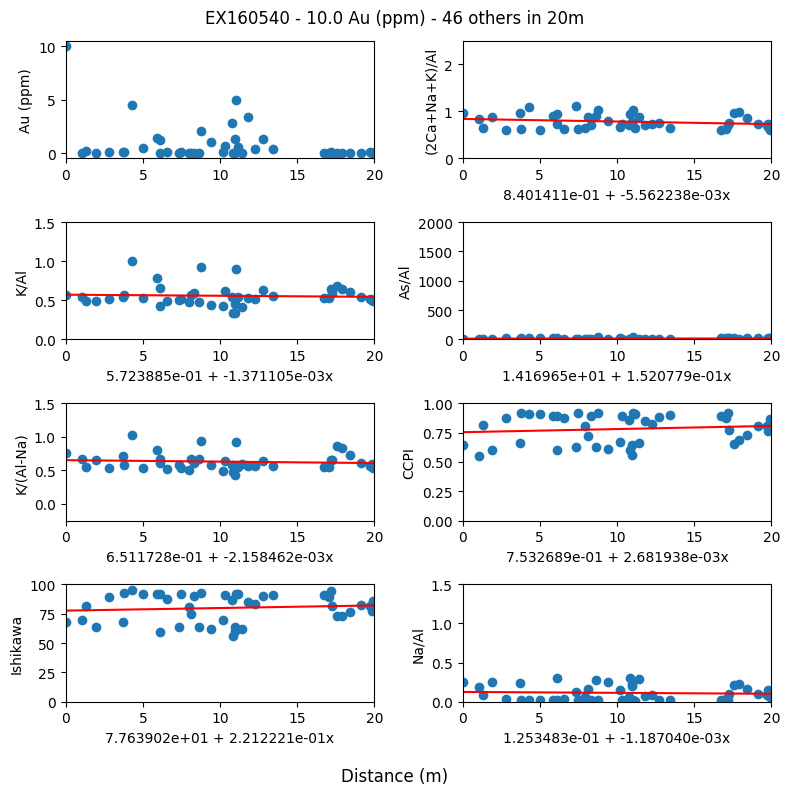

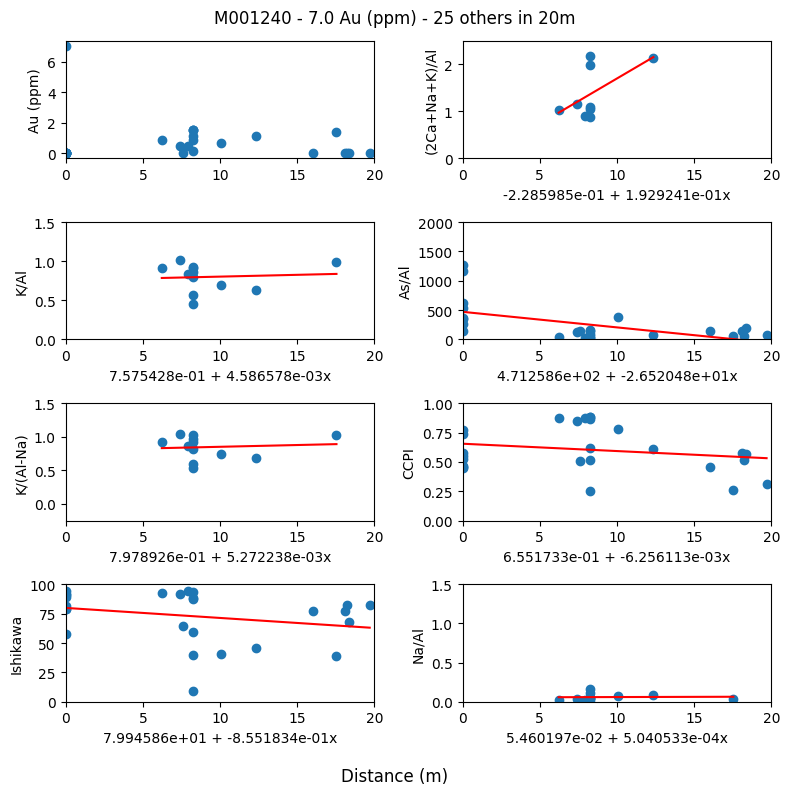

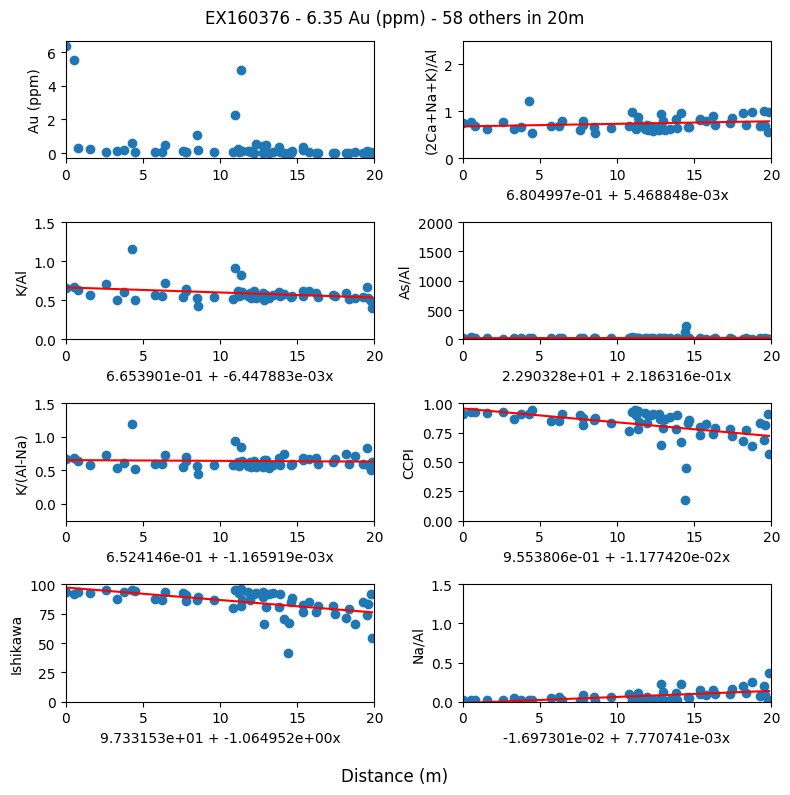

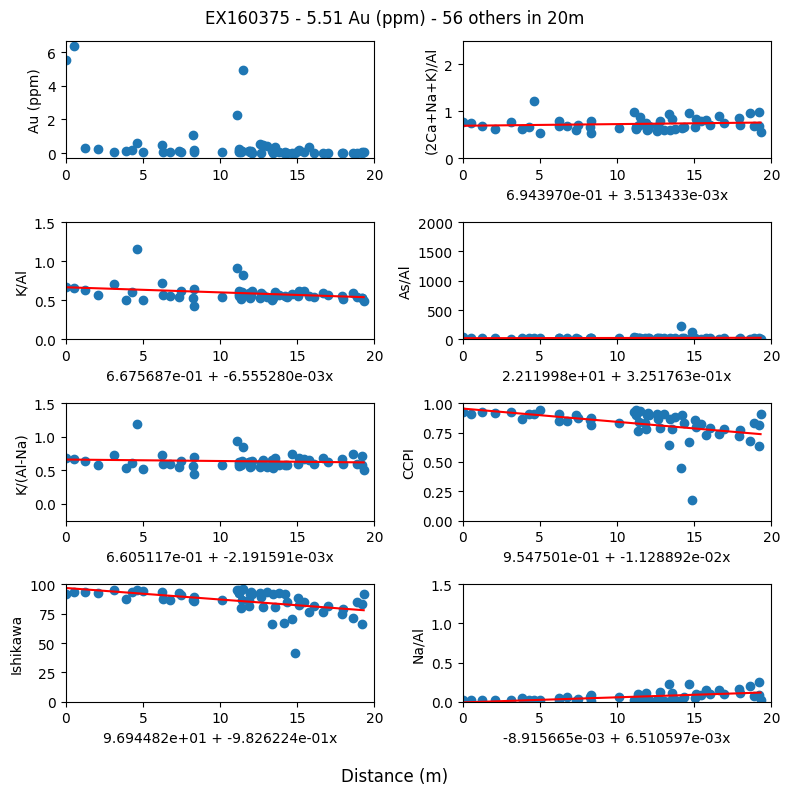

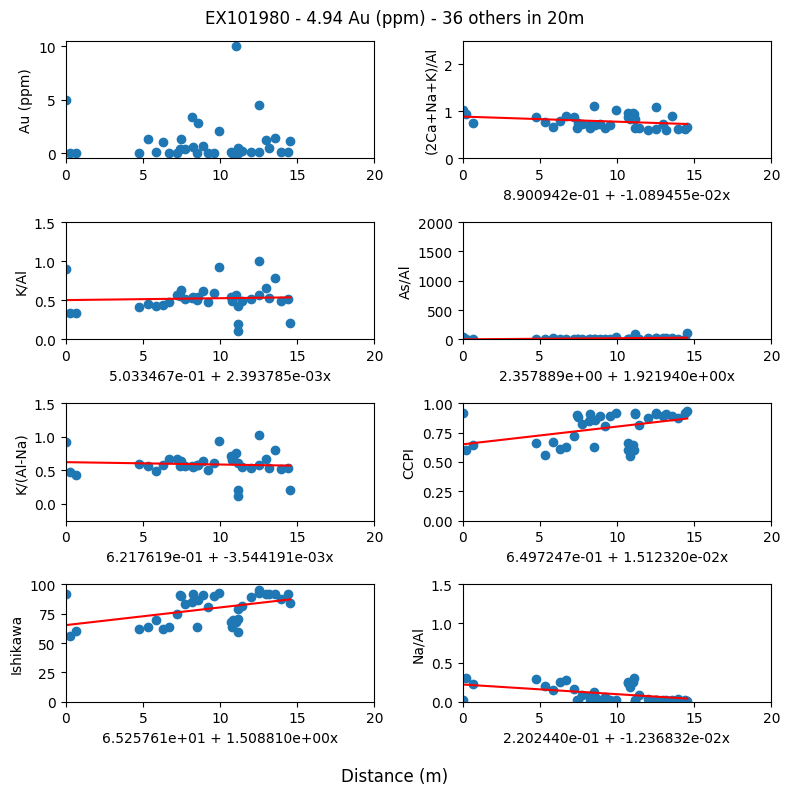

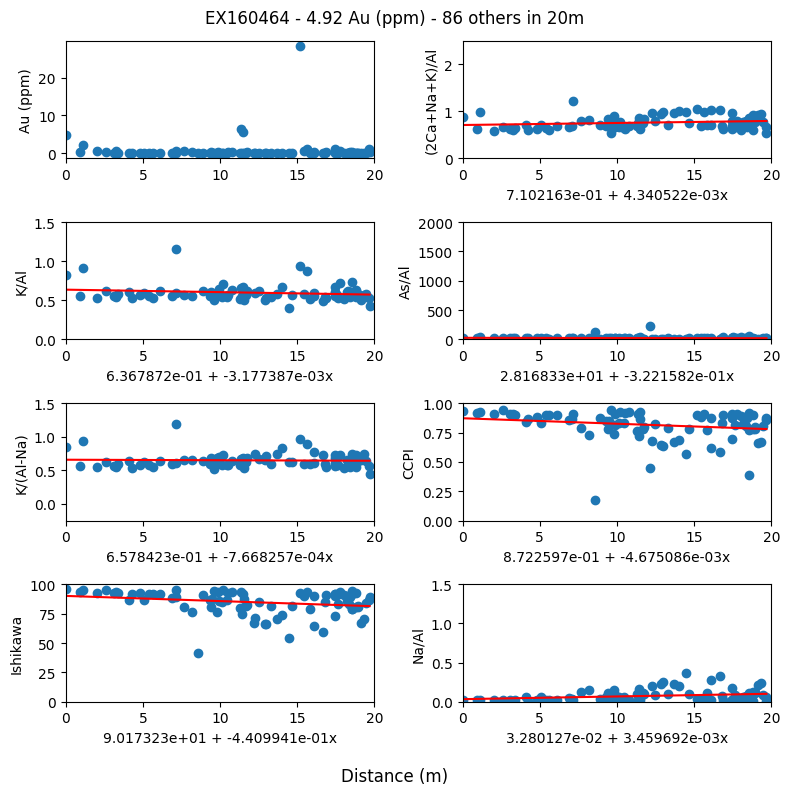

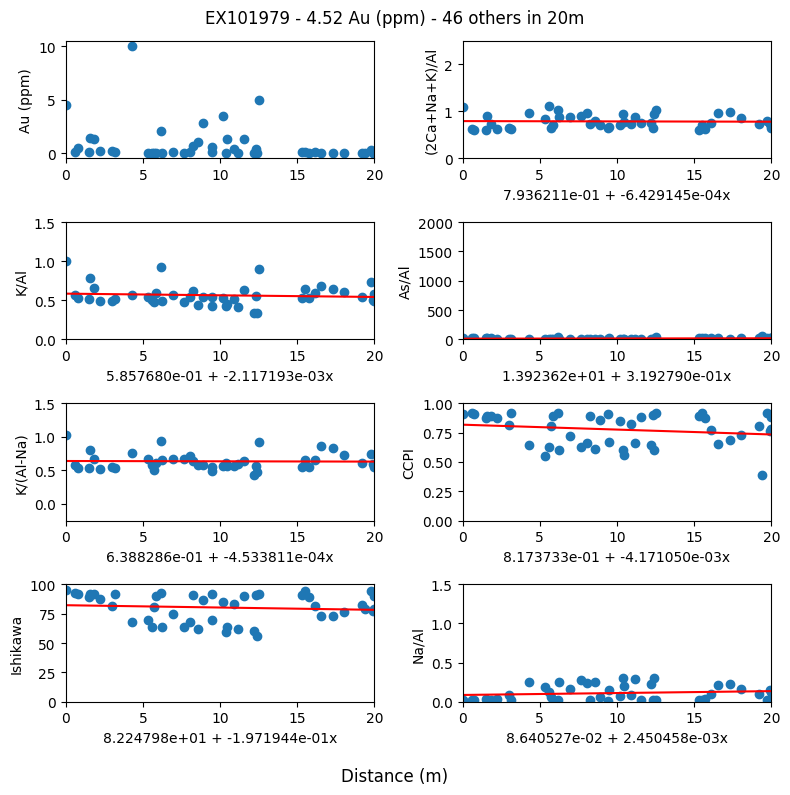

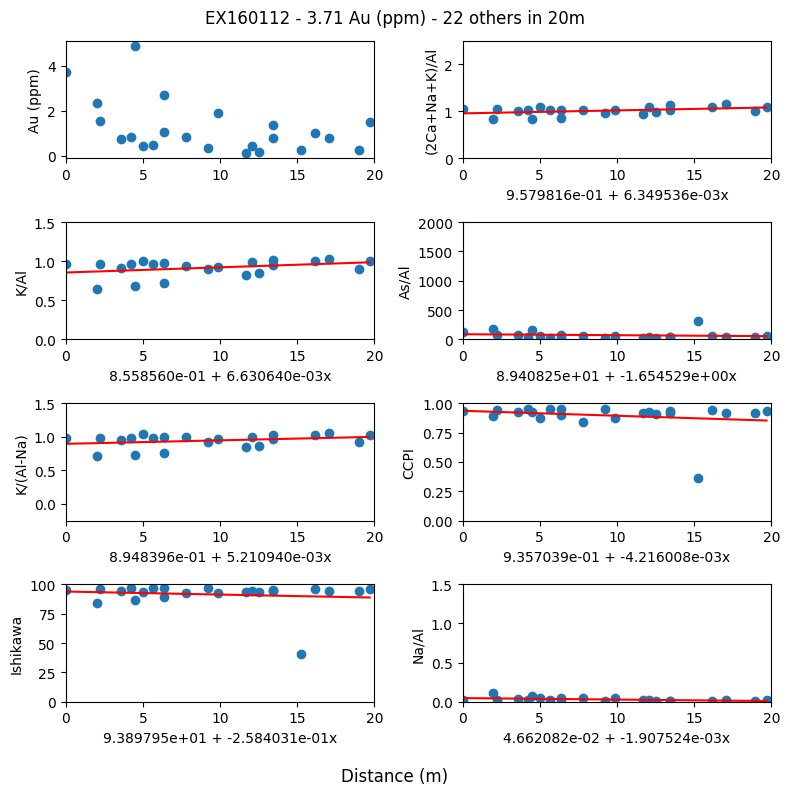

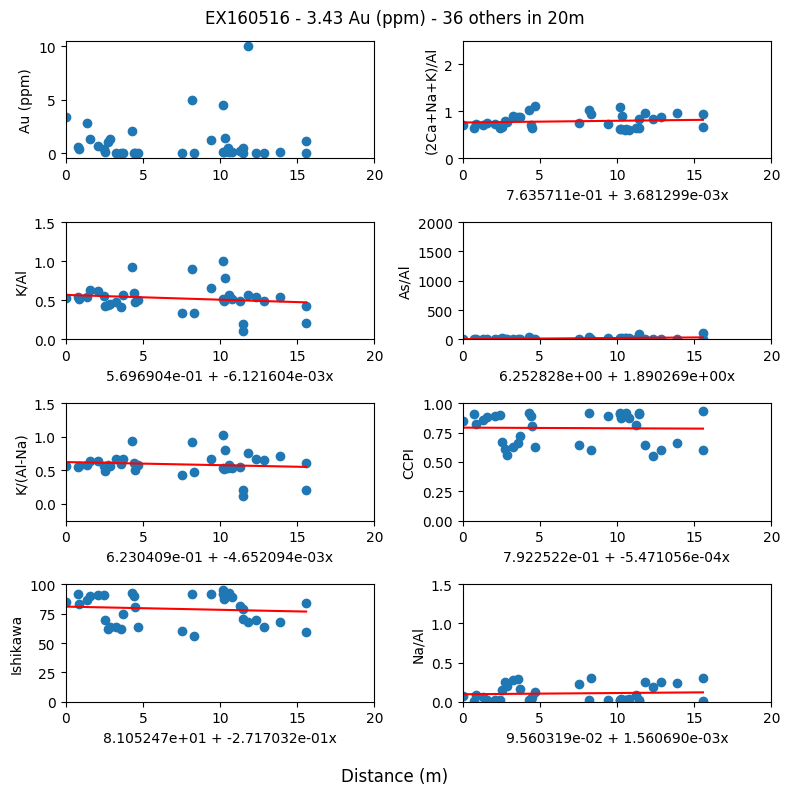

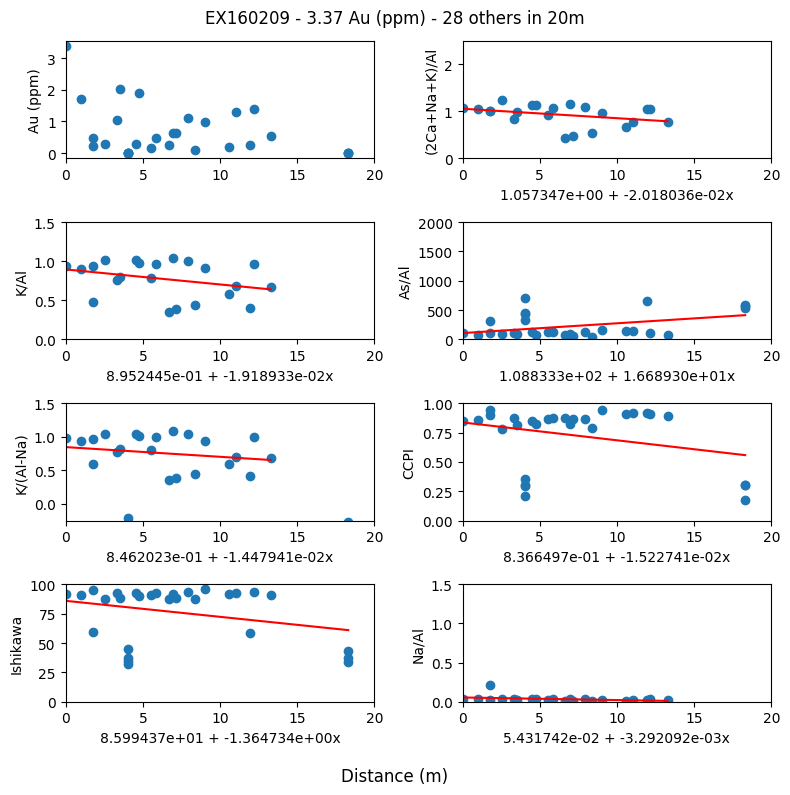

In [10]:
create_plots(data_frame, RATIO_COLUMNS)
# create_plots(data_frame, RATIO_CONSTITUTENT_COLUMNS)

In [26]:
def create_3d_plots(data_frame: geopandas.GeoDataFrame, columns: list[str]):
    for index, row in data_frame.sort_values(by = [TARGET_COLUMN], ascending = [False]).iterrows():
        if row[TARGET_COLUMN] < THRESHOLD:
            break
        other_rows: geopandas.GeoDataFrame = data_frame[data_frame.index != index]
        other_rows = other_rows[other_rows[GEOMETRY_COLUMN].apply(lambda x: distance(x, row[GEOMETRY_COLUMN]) <= RADIUS)]

        if len(other_rows) < 5:
           continue

        subset_index: pandas.Index = pandas.Index([index]).union(other_rows.index)
        subset_data_frame: geopandas.GeoDataFrame = data_frame.loc[subset_index]

        NUMBER_OF_COLUMNS: int = 2
        NUMBER_OF_ROWS: int = int(math.ceil(len(columns) / NUMBER_OF_COLUMNS))

        figure: matplotlib.figure.Figure
        axes: numpy.ndarray[matplotlib.axes.Axes]
        figure, axes = matplotlib.pyplot.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, figsize = (8, 16), subplot_kw = { "projection": "3d" })

        for index, column in enumerate(columns):
            # figure: matplotlib.figure.Figure = matplotlib.pyplot.figure()
            # axes: matplotlib.axes.Axes = figure.add_subplot(projection = "3d")

            row_index: int = int(math.floor(index / NUMBER_OF_COLUMNS))
            column_index: int = index % NUMBER_OF_COLUMNS

            z_min: Optional[float] = None
            z_max: Optional[float] = None
            scalar_mappable: Optional[matplotlib.cm.ScalarMappable] = None

            if column in COLUMN_LIMITS:
                z_min = COLUMN_LIMITS[column][0]
                z_max = COLUMN_LIMITS[column][1]
                colormap: matplotlib.cm.Colormap = matplotlib.pyplot.get_cmap("Blues")
                scalar_mappable: matplotlib.cm.ScalarMappable = matplotlib.cm.ScalarMappable(norm = matplotlib.colors.Normalize(vmin = z_min, vmax = z_max), cmap = colormap)

            axes[row_index, column_index].scatter(subset_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x - row[GEOMETRY_COLUMN].x), subset_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y - row[GEOMETRY_COLUMN].y), subset_data_frame[column], color = subset_data_frame.apply(lambda x: "red" if x[ID_COLUMN] == row[ID_COLUMN] else scalar_mappable.to_rgba(x[column]) if scalar_mappable is not None else "blue", axis = 1))
            for point_index, point_row in subset_data_frame.iterrows():
                axes[row_index, column_index].plot([point_row[GEOMETRY_COLUMN].x - row[GEOMETRY_COLUMN].x, point_row[GEOMETRY_COLUMN].x - row[GEOMETRY_COLUMN].x], [point_row[GEOMETRY_COLUMN].y - row[GEOMETRY_COLUMN].y, point_row[GEOMETRY_COLUMN].y - row[GEOMETRY_COLUMN].y], [0, point_row[column]], color = "black", alpha = 0.25)
            axes[row_index, column_index].set_xlim(-RADIUS, RADIUS)
            axes[row_index, column_index].set_xlabel("East")
            axes[row_index, column_index].set_ylim(-RADIUS, RADIUS)
            axes[row_index, column_index].set_ylabel("North")
            axes[row_index, column_index].set_zlim(z_min, z_max)
            axes[row_index, column_index].set_zlabel(column)
            axes[row_index, column_index].set_box_aspect(aspect = None, zoom = 0.8)

            title: str = f"{row["SampleNumber"]} - {row[TARGET_COLUMN]} {TARGET_COLUMN} - {len(other_rows)} others in {RADIUS}m"

        figure.suptitle(title)
        figure.tight_layout()
        figure.show()

In [290]:
# create_3d_plots(data_frame[data_frame[DOMAIN_COLUMN] == 1], RATIO_COLUMNS)
create_3d_plots(data_frame[data_frame[DOMAIN_COLUMN] == 1], RATIO_CONSTITUTENT_COLUMNS)

In [300]:
def create_correlation_plots(data_frame: geopandas.GeoDataFrame, columns: list[str]):
    NUMBER_OF_COLUMNS: int = 2
    NUMBER_OF_ROWS: int = int(math.ceil(len(columns) / NUMBER_OF_COLUMNS))

    figure: matplotlib.figure.Figure
    axes: numpy.ndarray[matplotlib.axes.Axes]
    figure, axes = matplotlib.pyplot.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, figsize = (8, 8))

    for index, column in enumerate(columns):
        row_index: int = int(math.floor(index / NUMBER_OF_COLUMNS))
        column_index: int = index % NUMBER_OF_COLUMNS

        axes[row_index, column_index].scatter(data_frame[TARGET_COLUMN], data_frame[column])
        axes[row_index, column_index].set_ylabel(column)

        if column in COLUMN_LIMITS:
            y_min: Optional[float] = COLUMN_LIMITS[column][0]
            y_max: Optional[float] = COLUMN_LIMITS[column][1]

            axes[row_index, column_index].set_ylim(y_min, y_max)

    figure.tight_layout()
    figure.show()




#### 2D Desity Plot

In [62]:
def create_2d_density_plot(data_frame: geopandas.GeoDataFrame, columns: list[str]):
    NUMBER_OF_COLUMNS: int = 2
    NUMBER_OF_ROWS: int = int(math.ceil(len(columns) / NUMBER_OF_COLUMNS))

    figure: matplotlib.figure.Figure
    axes: numpy.ndarray[matplotlib.axes.Axes]
    figure, axes = matplotlib.pyplot.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, figsize = (8, 8))

    for index, column in enumerate(columns):
        row_index: int = int(math.floor(index / NUMBER_OF_COLUMNS))
        column_index: int = index % NUMBER_OF_COLUMNS
        
        sns.kdeplot(data_frame, x=TARGET_COLUMN, y=column, ax=axes[row_index, column_index], fill=False, cmap="viridis", thresh=0.05)
        axes[row_index, column_index].set_ylabel(column)

        if column in COLUMN_LIMITS:
            x_min: Optional[float] = COLUMN_LIMITS[column][0]
            x_max: Optional[float] = COLUMN_LIMITS[column][1]

            axes[row_index, column_index].set_xlim(0, 50)

    figure.tight_layout()
    figure.show()


# def create_2d_density_plot(data_frame: gpd.GeoDataFrame, columns: list[str]):
#     NUMBER_OF_COLUMNS: int = 2
#     NUMBER_OF_ROWS: int = int(math.ceil(len(columns) / NUMBER_OF_COLUMNS))

#     fig = sp.make_subplots(rows=NUMBER_OF_ROWS, cols=NUMBER_OF_COLUMNS, subplot_titles=columns)

#     for index, column in enumerate(columns):
#         row_index: int = int(math.floor(index / NUMBER_OF_COLUMNS))
#         column_index: int = index % NUMBER_OF_COLUMNS
        
#         density_contour = px.density_contour(data_frame, x=TARGET_COLUMN, y=column)
        
#         for trace in density_contour.data:
#             fig.add_trace(trace, row=row_index+1, col=column_index+1)
        
#         fig.update_yaxes(title_text=column, row=row_index+1, col=column_index+1)
        
#         # if column in column_limits:
#         fig.update_xaxes(range=(0,50))
#         fig.update_yaxes(range=(0,500))

#     fig.update_layout(height=800, width=800, title_text="2D Density Plots")
#     fig.show()

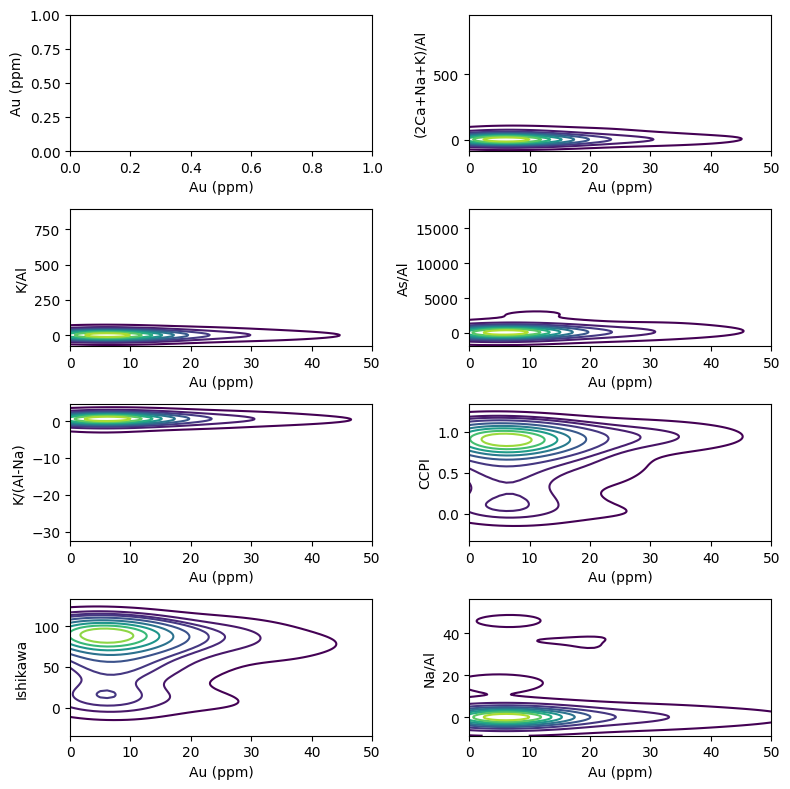

In [63]:
import plotly.express as px
import plotly.subplots as sp
import math
import pandas as pd
import geopandas as gpd

create_2d_density_plot(data_frame[data_frame[TARGET_COLUMN].gt(THRESHOLD)], RATIO_COLUMNS)

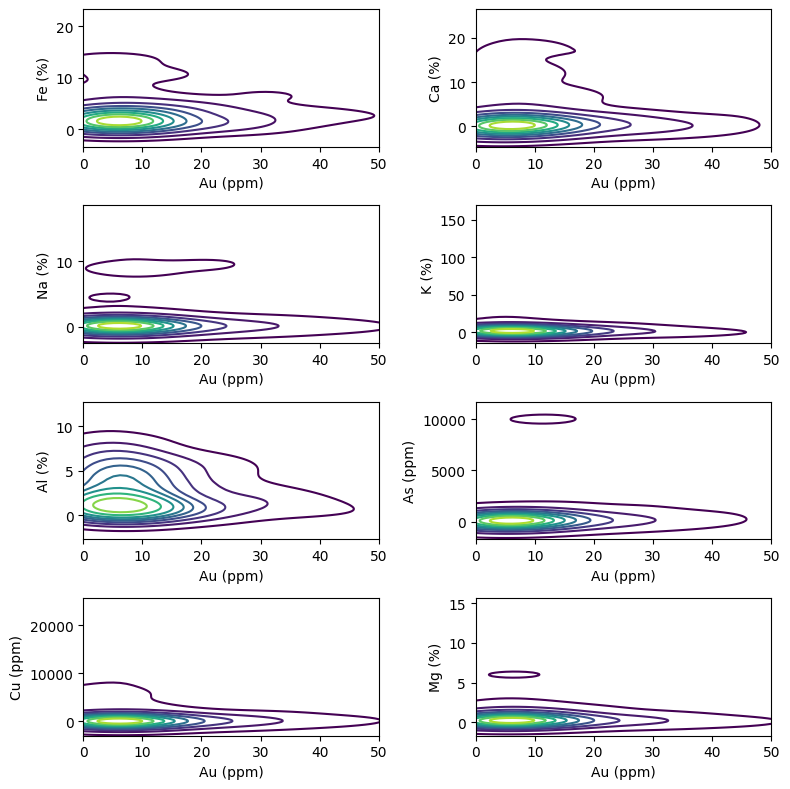

In [64]:
create_2d_density_plot(data_frame[data_frame[TARGET_COLUMN].gt(THRESHOLD)], RATIO_CONSTITUTENT_COLUMNS)

In [32]:
# create_correlation_plots(data_frame[data_frame[TARGET_COLUMN].le(50)], RATIO_COLUMNS)
# create_correlation_plots(data_frame[data_frame[TARGET_COLUMN].le(50)], RATIO_CONSTITUTENT_COLUMNS)

In [33]:
# def create_correlation_plot(data_frame: geopandas.GeoDataFrame, column: str):
#     figure, axes = matplotlib.pyplot.subplots(nrows = 1, ncols = 1, figsize = (8, 8))
    
#     matplotlib.pyplot.scatter(data_frame[TARGET_COLUMN], data_frame[column])
#     axes.set_ylabel(column)
    
#     figure.tight_layout()
#     figure.show()

# for column in data_frame.columns[data_frame.columns.get_loc("Al (%)"):data_frame.columns.get_loc("Zr (ppm)")]:
#     create_correlation_plot(data_frame[data_frame[TARGET_COLUMN].le(50)], column)

In [34]:
def create_null_domain_plots(data_frame: geopandas.GeoDataFrame, reference_points_data_frame: geopandas.GeoDataFrame, columns: list[str]):
    for index, row in reference_points_data_frame.iterrows():
        subset_data_frame: geopandas.DataFrame = data_frame.copy()

        DISTANCE_COLUMN: str = "Distance"
        NUMBER_OF_COLUMNS: int = 2
        NUMBER_OF_ROWS: int = int(math.ceil(len(columns) / NUMBER_OF_COLUMNS))

        subset_data_frame[DISTANCE_COLUMN] = subset_data_frame.apply(lambda x: distance(x[GEOMETRY_COLUMN], row[GEOMETRY_COLUMN]), axis = 1)
        
        figure: matplotlib.figure.Figure
        axes: numpy.ndarray[matplotlib.axes.Axes]
        figure, axes = matplotlib.pyplot.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, figsize = (8, 8))

        for index, column in enumerate(columns):            
            y_min: Optional[float] = None
            y_max: Optional[float] = None

            if column in COLUMN_LIMITS:
                y_min = COLUMN_LIMITS[column][0]
                y_max = COLUMN_LIMITS[column][1]

            row_index: int = int(math.floor(index / NUMBER_OF_COLUMNS))
            column_index: int = index % NUMBER_OF_COLUMNS
            axes[row_index, column_index].scatter(subset_data_frame[DISTANCE_COLUMN], subset_data_frame[column])
            axes[row_index, column_index].set_ylabel(column)
            axes[row_index, column_index].set_ylim(y_min, y_max)

            if column in COLUMN_FIT_OPTIONS:
                best_fit_subset_data_frame: geopandas.GeoDataFrame = subset_data_frame[subset_data_frame[column].apply(lambda x: (y_min is None or y_min <= x) and (y_max is None or x <= y_max))]
                # linear_regression_result: scipy.stats.LinregressResult = scipy.stats.linregress(best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column])
                # best_fit_function: IFunction = Polynomial([linear_regression_result.intercept, linear_regression_result.slope])
                best_fit_function: IFunction = fit_function(Polynomial, best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column], bounds = Bounds([0], [10000]))
                best_fit_X, best_fit_Y = best_fit_function.to_discrete(0, 150, 1000)
                axes[row_index, column_index].plot(best_fit_X, best_fit_Y, linestyle = "-", color = "red")
                axes[row_index, column_index].set_xlabel(str(best_fit_function))

            axes[row_index, column_index].set_xlim(0, 150)

        figure.supxlabel("Distance (m)")
        title: str = f"{row["SampleNumber"]} - {row[TARGET_COLUMN]} {TARGET_COLUMN}"

        figure.suptitle(title)
        figure.tight_layout()
        figure.show()

In [303]:
null_domain_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[GEOMETRY_COLUMN].apply(lambda x: NULL_DOMAIN_BOTTOM_LEFT.x <= x.x and x.x <= NULL_DOMAIN_TOP_RIGHT.x and NULL_DOMAIN_BOTTOM_LEFT.y <= x.y and x.y <= NULL_DOMAIN_TOP_RIGHT.y)]
null_domain_reference_data_frame: geopandas.GeoDataFrame = null_domain_data_frame[null_domain_data_frame["SampleNumber"] == "M021872"]

create_null_domain_plots(null_domain_data_frame, null_domain_data_frame[null_domain_data_frame["SampleNumber"] == "M021872"], RATIO_COLUMNS)
create_null_domain_plots(null_domain_data_frame, null_domain_data_frame[null_domain_data_frame["SampleNumber"] == "M021872"], RATIO_CONSTITUTENT_COLUMNS)

In [304]:
data_subset = data_frame[data_frame[TARGET_COLUMN].ge(1)][data_frame["CCPI"].le(1)]
power: PowerWithOffset = fit_function(PowerWithOffset, data_subset[TARGET_COLUMN], data_subset["CCPI"], [-1], fixed_parameters = { "r": -1, "C": 1 }, bounds = ([-numpy.inf], [0]))
print(power)

figure: matplotlib.figure.Figure
axes: numpy.ndarray[matplotlib.axes.Axes]
figure, axes = matplotlib.pyplot.subplots(nrows = 1, ncols = 1, figsize = (8, 8))
axes.scatter(data_frame[TARGET_COLUMN], data_frame["CCPI"])
axes.plot(numpy.linspace(0, 50, 100), [power(x) for x in numpy.linspace(0, 50, 100)], 'r-')

axes.set_xlim(0, 50)
axes.set_ylim(0, 1)

In [305]:
data_subset = data_frame[data_frame[TARGET_COLUMN].ge(0.01)]
power: PowerWithOffset = fit_function(Power, data_subset[TARGET_COLUMN], data_subset["Ca (%)"], [1], fixed_parameters = { "r": -1 }, bounds = ([0], [100]))
print(power)

figure: matplotlib.figure.Figure
axes: numpy.ndarray[matplotlib.axes.Axes]
figure, axes = matplotlib.pyplot.subplots(nrows = 1, ncols = 1, figsize = (8, 8))
axes.scatter(data_frame[TARGET_COLUMN], data_frame["Ca (%)"])
axes.plot(numpy.linspace(0, 50, 100), [power(x) for x in numpy.linspace(0, 50, 100)], 'r-')

axes.set_xlim(0, 50)

In [306]:
data_subset = data_frame[data_frame[TARGET_COLUMN].ge(2)][data_frame["Na/Al"].le(1)]
power: Power = fit_function(Power, data_subset[TARGET_COLUMN], data_subset["Na/Al"], [0.4], fixed_parameters = { "r": -1 }, bounds = ([0], [numpy.inf]))
print(power)

figure: matplotlib.figure.Figure
axes: numpy.ndarray[matplotlib.axes.Axes]
figure, axes = matplotlib.pyplot.subplots(nrows = 1, ncols = 1, figsize = (8, 8))
axes.scatter(data_frame[TARGET_COLUMN], data_frame["Na/Al"])
axes.plot(numpy.linspace(0, 50, 100), [power(x) for x in numpy.linspace(0, 50, 100)], 'r-')

axes.set_xlim(0, 50)
axes.set_ylim(0, 1)

In [13]:
import pandas

In [15]:
data_frame = pandas.read_excel('../dash/data/fingerprint.xlsx')
# data_frame['im_url'] = np.nan
# data_frame = get_im_urls(data_frame, TARGET_COLUMN)

# Logarithmic scaling of 'Au' values
data_frame['Au_log'] = numpy.log1p(data_frame[TARGET_COLUMN])

In [19]:
# Create the scatter mapbox plot
mapbox_token = "pk.eyJ1IjoiemVlcmFrd3luZSIsImEiOiJjazdyenBsbzAwaW9wM2ZudjFnbmZlNDBhIn0.yVq3jzmrcnc5QeUPCkKnLQ"

fig = go.Figure(go.Scattermapbox(
    name='Data',
    lat=data_frame['Latitude'],
    lon=data_frame['Longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(  # Set the marker color
        
        opacity=0.25,
        color = '#818589',

    ),
    text=data_frame[TARGET_COLUMN],  # Tooltip text
))

fig.add_trace(go.Scattermapbox(
    showlegend=False,
    lat=data_frame['Latitude'],
    lon=data_frame['Longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        # symbol='diamond',
        size=data_frame['Au_log']*5,  # Scale the marker size for better visualization
        color=data_frame['Au_log'],  # Set the marker color
        opacity=0.8,
        colorscale='greens',  # Optionally set the colorscale

    ),
    text=data_frame[TARGET_COLUMN],  # Tooltip text
))

fig.add_trace(go.Scattermapbox(
    name='Gold vs Distance',
    lat=data_frame[~data_frame['im_url'].isna()]['Latitude'],
    lon=data_frame[~data_frame['im_url'].isna()]['Longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        symbol='circle',
        size=7,
        color = '#FFD700',

        # opacity=0.8,
    )
))
# Update layout to center the map and set the zoom level
fig.update_layout(
    width=800,
    height=800,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    # height=550,
    mapbox={
        'accesstoken': mapbox_token,
        'center': {'lat': 30.411669330, 'lon': -110.457374511},
        'zoom': 11
    },
    mapbox_style="open-street-map",
    # mapbox_style="satellite-streets",
    margin={"r":0, "t":0, "l":5, "b":0}
)

fig.update_traces(hoverinfo="none", hovertemplate=None)

